Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Digital Music
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


## import dataset

In [3]:
dig_music = pd.read_csv("../datasets/Digital_Music.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])
dataset_name = 'Amazon_Digital_Music'
user_col = 'user_id'

dig_music.shape

(1584082, 4)

In [4]:
dig_music.head()

,user_id,item_id,rating,timestamp
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400
3,0001388703,A3A0W7FZXM0IZW,5.0,1354406400
4,0001388703,A12R54MKO17TW0,5.0,1325894400


## keeping only users that have rated more than 5 times

In [5]:
dig_music['user_id'].value_counts() >= 5

B0135P6PZA     True
B00M8JCW3E     True
B00CZF8B68     True
B00NPZI1ZS     True
B00U3WJHCW     True
              ...  
B000QM5VD8    False
B00OR27PT6    False
B00LM6BIAW    False
B000X1R0DQ    False
B0054OGH4U    False
Name: user_id, Length: 456992, dtype: bool

In [6]:
k_core_users = dig_music['user_id'].value_counts()[ dig_music['user_id'].value_counts() >= 5 ].index
k_core_users

Index(['B0135P6PZA', 'B00M8JCW3E', 'B00CZF8B68', 'B00NPZI1ZS', 'B00U3WJHCW',
       'B0092MKTL2', 'B005MVLI8A', 'B00136NUG6', 'B0170K9UTO', 'B0099G7KDQ',
       ...
       'B004B3DKFO', 'B0013AUQUU', 'B001NU2158', 'B00BTLOPSM', 'B00J49PFS0',
       'B003O3PWD0', 'B0001FT52S', 'B001PJ5V04', 'B000XNVT2C', 'B004MFL5QW'],
      dtype='object', length=50110)

In [7]:
data = dig_music.set_index('user_id').loc[k_core_users].reset_index()
data.shape

(998936, 4)

## Keep only high ratings (the quantile 0.8 -> 5.0 ratings)

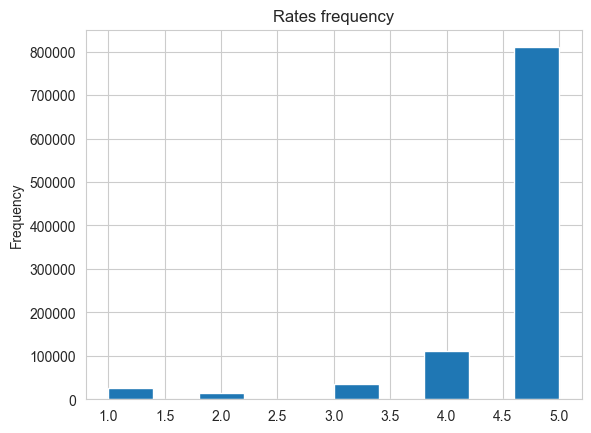

In [8]:
data['rating'].plot(kind='hist', title='Rates frequency');

In [9]:
pos_ratings = np.quantile(data['rating'], q=0.8)
pos_ratings

5.0

In [10]:
data = data[ data['rating'] == pos_ratings ].drop(columns='rating')
data.head()

,user_id,item_id,timestamp
0,B0135P6PZA,A1N25NY4EQL7I6,1443225600
1,B0135P6PZA,A14K5YWVJ1SV38,1443225600
2,B0135P6PZA,A11Y3UKBMR9VTT,1443225600
3,B0135P6PZA,AM327SL7RBMMW,1443139200
4,B0135P6PZA,ARTPRZWG3M212,1443139200


In [11]:
# number of remaining cases
data.shape[0]

809899

## Convert timestamp

In [12]:
%%time
# data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x) ) # convert unix timestamp to date
# data = data.sort_values(by='date') # sort by date

data['date'] = data['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date

CPU times: total: 391 ms
Wall time: 716 ms


In [13]:
data.head()

,user_id,item_id,timestamp,date
39318,9714721180,A2SY49Z6H96QVR,877305600,1997-10-20
594530,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-28
594538,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-28
309802,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-22
309756,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-22


In [14]:
data.tail()

,user_id,item_id,timestamp,date
696139,B01GK9XH2C,AAP8SBSG2T8NX,1538179200,2018-09-29
883502,B01G7OH4KG,A1UACDAXDOWB2H,1538265600,2018-09-30
268022,B01GPDFR26,A312L5Z8SW61FR,1538265600,2018-09-30
262810,B01G4DH4AU,A7O6RHCU9RZ8L,1538352000,2018-10-01
230965,B01H7XADLS,A1X087SYY8ZFGC,1538438400,2018-10-02


In [15]:
%%time
# keep year-month
data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

CPU times: total: 8.86 s
Wall time: 11.2 s


In [16]:
data.head()

,user_id,item_id,timestamp,date
39318,9714721180,A2SY49Z6H96QVR,877305600,1997-10-01
594530,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-01
594538,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-01
309802,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-01
309756,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-01


---------------------------------------------------------------------------------------------
### Data.head() is showing different results from Klismam's...

In [17]:
# data[data.timestamp==877305600]

-- example ---------------------------

In [18]:
# import pytz
# from datetime import datetime

In [19]:
# pytz.all_timezones_set.intersection(['GMT'])

In [20]:
# ts = 877305600

In [21]:
# datetime.fromtimestamp(ts)

In [22]:
# utc_dt = datetime.utcfromtimestamp(ts)
# utc_dt

In [23]:
# aware_utc_dt = utc_dt.replace(tzinfo=pytz.utc)

# tz = pytz.timezone('GMT')
# dt = aware_utc_dt.astimezone(tz)
# dt

In [24]:
# dt = datetime.fromtimestamp(ts, tz)
# dt

-- end example ---------------------------

In [25]:
# data['date_utc'] = data['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x) ) # convert unix timestamp to date
# data = data.sort_values(by='date_utc') # sort by date

In [26]:
# data.head()

In [27]:
# data.tail()

".fromtimestamp() might fail for past dates if a local timezone had different utc offset. You need a historic timezone database such as provided by pytz module (or your OS). Or just work in UTC and use .utcfromtimestamp()" - (https://stackoverflow.com/questions/3682748/converting-unix-timestamp-string-to-readable-date)

In [28]:
# data = data.drop(columns=['date', 'date_utc'])
# data['date'] = data['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x) ) # convert unix timestamp to date
# data = data.sort_values(by='date') # sort by date
# data.head()

In [29]:
# %%time
# # keep year-month
# data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

In [30]:
# data.head()

now it's SOLVED.
because of the drop of date, it seems that the utc problem was not an issue, but now it's certain.
___

## Evaluating Time defined Buckets 

In [31]:
%%time
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: total: 172 ms
Wall time: 250 ms


### plot interactions_per_month

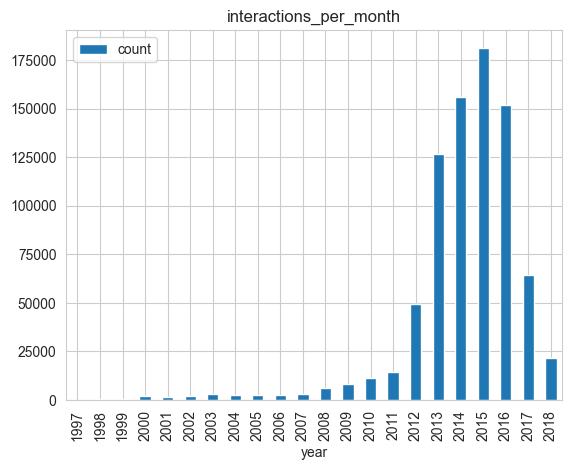

In [32]:
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.year
_.groupby('date').sum().plot(kind='bar', 
                             title='interactions_per_month').set_xlabel('year');

### sample_year_month

In [33]:
sample_year_month = [('2014', '%Y'), ('2014-10', '%Y-%m')]
sample_year_month_start = sample_year_month[0][0]
sample_year_month_end = sample_year_month[1][0]

In [34]:
# sample_year_month[1] <= date < sample_year_month[1]
y_filter = (datetime.strptime(*sample_year_month[0]) <= data['date']) & (data['date'] < datetime.strptime(*sample_year_month[1]))

# 2014 <= date < 2014-04
# y_filter = (data['date'] < datetime.strptime('2014-04', '%Y-%m')) & (datetime.strptime('2014', '%Y') <= data['date']) 

# 2014 <= date < 2015
# y_filter = (data['date'] < datetime.strptime('2015', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 

### plot sample_year_month 

104028


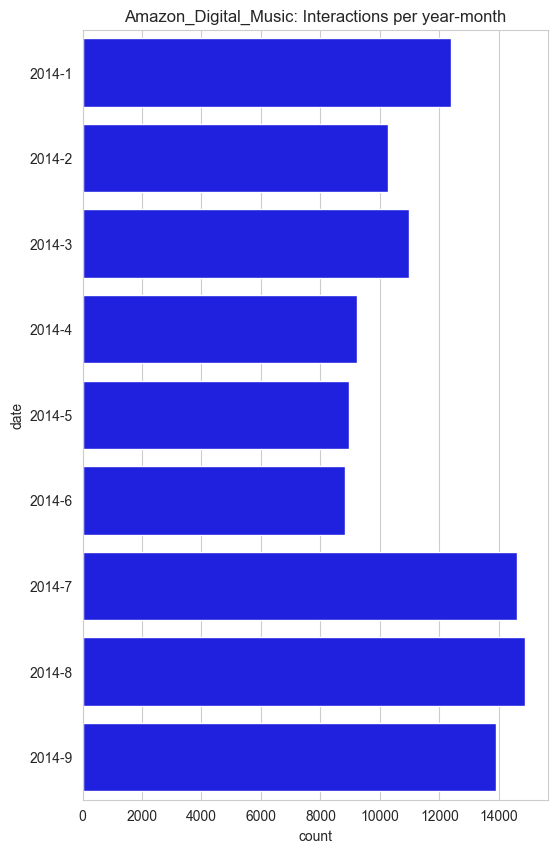

In [35]:
print(data[y_filter].shape[0])
plot_interactions_per_month(data=data[y_filter].reset_index(), dataset_name=dataset_name)

In [36]:
df_only_high_ratings = data.copy()
data = data[y_filter]

In [37]:
# number of remaining cases
data.shape[0]

104028

## Sampling the dataset - only most frequent users (overall)

In [38]:
data.groupby(by=['user_id'])['date'].nunique()

user_id
0001377647    5
0001388703    3
0001526146    3
0001527134    3
0006882919    2
             ..
B01E9SVVHE    3
B01EE9N52C    2
B01FLMZ50G    1
B01FXZSQZC    2
B01HC8FQME    6
Name: date, Length: 26467, dtype: int64

In [39]:
%%time
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()

CPU times: total: 62.5 ms
Wall time: 106 ms


### plot user_freq_over_months

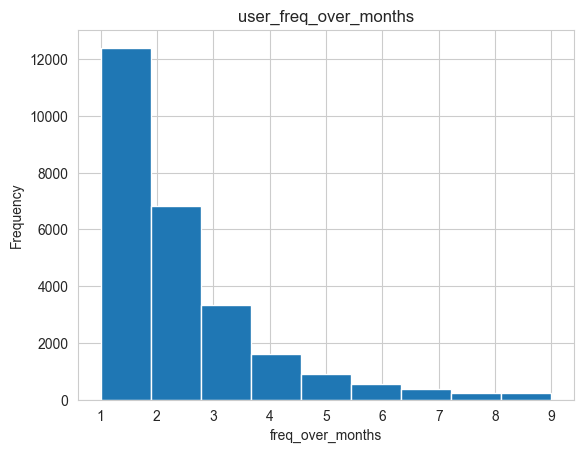

In [40]:
user_freq_over_months.plot(kind='hist',
                           bins=user_freq_over_months.max(),
                           title='user_freq_over_months').set_xlabel('freq_over_months');

In [41]:
_ = data.set_index('user_id').copy()

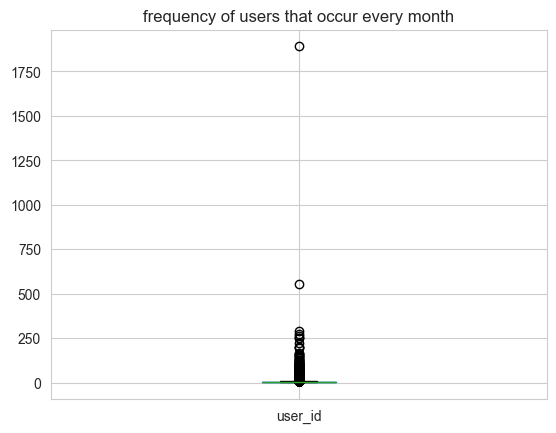

In [42]:
# frequency of users that occur every month:
_.reset_index()['user_id'].value_counts().plot(kind='box',
                                               title='frequency of users that occur every month');

In [43]:
data['user_id'].value_counts()

B00CZF8B68    1890
B00GLP4DMO     552
B00IKS2BHY     289
B0092MKTL2     275
B00HNIEQNE     263
              ... 
B0007IK0Y6       1
B001HE3HM6       1
B000YN373A       1
B002EOWBZW       1
B001OAZ10Y       1
Name: user_id, Length: 26467, dtype: int64

In [44]:
# list of users
u = data['user_id'].value_counts().reset_index()['index'].to_list() 

In [45]:
print(data['user_id'].nunique())
print(len(u) == data['user_id'].nunique())

26467
True


In [46]:
data['user_id'].shape[0]

104028

In [47]:
p = (data['user_id'].value_counts()/data['user_id'].shape[0])
p

B00CZF8B68    0.018168
B00GLP4DMO    0.005306
B00IKS2BHY    0.002778
B0092MKTL2    0.002644
B00HNIEQNE    0.002528
                ...   
B0007IK0Y6    0.000010
B001HE3HM6    0.000010
B000YN373A    0.000010
B002EOWBZW    0.000010
B001OAZ10Y    0.000010
Name: user_id, Length: 26467, dtype: float64

In [48]:
# sample size of 75% of the users
prop = 0.75
s = round( len(u)*prop )
s

19850

### sampled_users

In [49]:
np.random.seed(42)
sampled_users = list( np.random.choice(u,               # list of users
                                       size=s,          # size of the sample, set to 75% of the #users
                                       replace=False,   # no repeat
                                       p=p) )           # probability of a user
sampled_users[:5]

['B008DZS61O', 'B001BKRJI4', 'B004LM7IS0', 'B000TEDBA8', 'B00JRE4AP6']

In [50]:
_.loc[sampled_users].shape

(95224, 3)

In [51]:
# unique items in the sample of users
_.loc[sampled_users]['item_id'].nunique()

63598

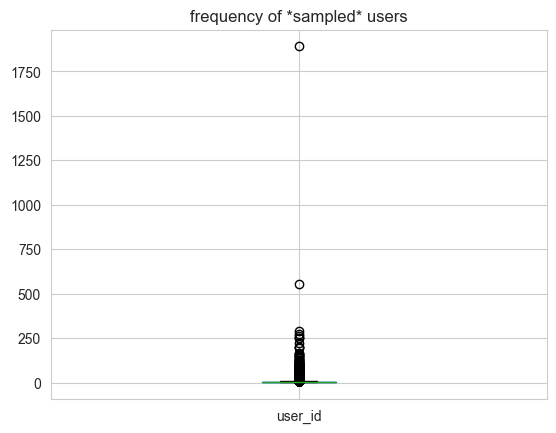

In [52]:
# frequency of users:
_.loc[sampled_users].reset_index()['user_id'].value_counts().plot(kind='box',
                                                                  title='frequency of *sampled* users');

CPU times: total: 141 ms
Wall time: 211 ms


Text(0.5, 0, 'freq_over_months of *sampled* users')

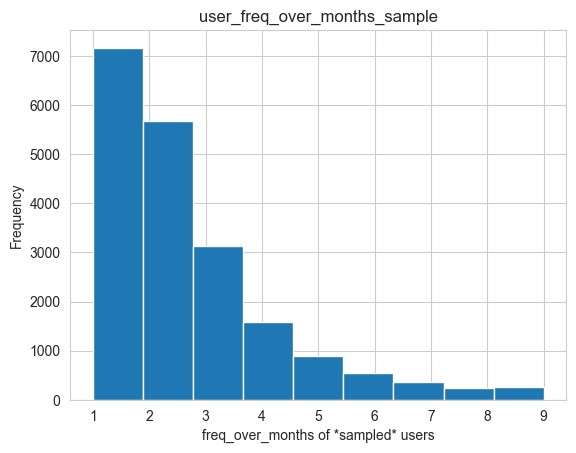

In [53]:
%%time
user_freq_over_months_sample = _.loc[sampled_users].reset_index().groupby(by=['user_id'])['date'].nunique()
user_freq_over_months_sample.plot(kind='hist',
                                  bins=user_freq_over_months_sample.max(),
                                  title='user_freq_over_months_sample').set_xlabel('freq_over_months of *sampled* users');


In [54]:
print('original - #users', dig_music['user_id'].nunique())
print('original - #items', dig_music['item_id'].nunique())

original - #users 456992
original - #items 840372


In [55]:
print('sampled time until '+str(sample_year_month_end)+' - #users', data['user_id'].nunique())
print('sampled time until '+str(sample_year_month_end)+' - #items', data['item_id'].nunique())

sampled time until 2014-10 - #users 26467
sampled time until 2014-10 - #items 68737


In [56]:
print('sampled users - #users', _.loc[sampled_users].reset_index()['user_id'].nunique())
print('sampled users - #items', _.loc[sampled_users].reset_index()['item_id'].nunique())

sampled users - #users 19850
sampled users - #items 63598


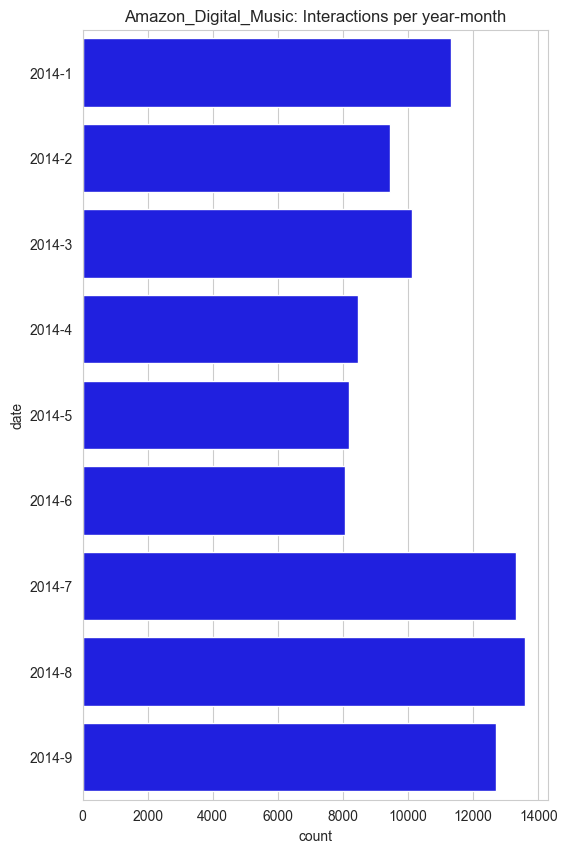

In [57]:
# %%time
# plot_interactions_per_month(data=_.loc[freq_users].reset_index(), dataset_name=dataset_name)
plot_interactions_per_month(data=_.loc[sampled_users].reset_index(), dataset_name=dataset_name)

In [58]:
df_sample_time = data.copy()

In [59]:
USE_THRESHOLD = True
# all users 0.002736
# USING prop = 0.75 increased performance by a bit in the first month, 0.004292 (0.002878) ?
# USING prop = 0.5 reduced performance in the first month  	0.001647
# USING prop = 0.25 reduced performance in the first month 0.002574

if USE_THRESHOLD: 
    data = _.loc[sampled_users].reset_index()
    data = data.sort_values(by=['timestamp', 'user_id', 'item_id'])
    print(data.shape[0])
else:
    print(data.shape[0])


# new sample
# sample_str = str(sample_year_month_start)+'_until_'+str(sample_year_month_end)
# data.to_csv('output/amazon_digmusic_dump/sampled_amazon_digmusic'+sample_str+'.csv', index=False)
data.to_csv('output/amazon_digmusic_dump/sampled_amazon_digmusic.csv', index=False)

95224


How many interactions occur in each month / year?

In [60]:
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: total: 93.8 ms
Wall time: 367 ms


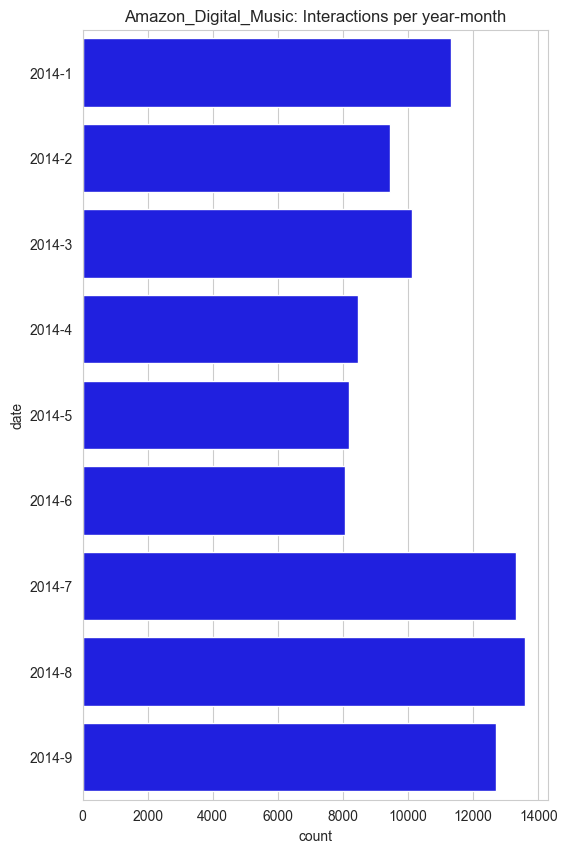

In [61]:
%%time
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [62]:
%%time
# 4min 59s
user_presence_df, user_month_interactions,\
    trimestres, user_trimestre_interactions,\
    semestres, user_semestre_interactions = get_interactions_info(data=data, 
                                                                    user_col=user_col,
                                                                    quarter_info=True, 
                                                                    semester_info=True)


0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
CPU times: total: 2min 43s
Wall time: 4min 45s


In [63]:
user_presence_df.head()

,UserID,month_%,trimestre_%,semestre_%
0,B00CRMX53S,1.0,1.0,1.0
1,B007V5XV30,1.0,1.0,1.0
2,B00GB1OY54,1.0,1.0,1.0
3,B00DW22TSO,1.0,1.0,1.0
4,B00EI6E17A,1.0,1.0,1.0


In [64]:
user_month_interactions.head()

,user_id,date,count
0,0001377647,2014-01-01,2
13755,B0013G1WF2,2014-01-01,1
13758,B0013G1WTS,2014-01-01,2
5087,B000W1AO4Y,2014-01-01,2
33234,B00AYSRFL0,2014-01-01,2


In [65]:
trimestres

[(Timestamp('2014-01-01 00:00:00'),
  Timestamp('2014-03-31 00:00:00', freq='3M')),
 (Timestamp('2014-04-01 00:00:00'),
  Timestamp('2014-06-30 00:00:00', freq='3M'))]

In [66]:
user_trimestre_interactions.head()

,0,1,2
0001377647,2.0,1.0,2.0
B0013G1WF2,1.0,0.0,1.0
B0013G1WTS,2.0,1.0,1.0
B000W1AO4Y,1.0,1.0,2.0
B00AYSRFL0,1.0,1.0,2.0


In [67]:
semestres

[(Timestamp('2014-01-01 00:00:00'),
  Timestamp('2014-06-30 00:00:00', freq='6M'))]

In [68]:
user_semestre_interactions.head()

,0,1
0001377647,3.0,2.0
B0013G1WF2,1.0,1.0
B0013G1WTS,3.0,1.0
B000W1AO4Y,2.0,2.0
B00AYSRFL0,2.0,2.0


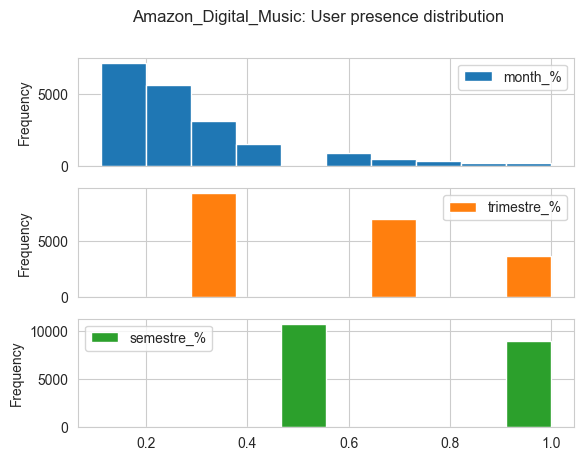

In [69]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name)

In [70]:
user_month_interactions.columns

Index(['user_id', 'date', 'count'], dtype='object')

In [75]:
user_trimestre_interactions.reset_index()

,index,0,1,2
0,0001377647,2.0,1.0,2.0
1,B0013G1WF2,1.0,0.0,1.0
2,B0013G1WTS,2.0,1.0,1.0
3,B000W1AO4Y,1.0,1.0,2.0
4,B00AYSRFL0,1.0,1.0,2.0
...,...,...,...,...
19845,B007IUFDAC,0.0,0.0,1.0
19846,B00IJBOTU4,0.0,0.0,1.0
19847,B001411UDU,0.0,0.0,1.0
19848,B007JOMCE2,0.0,0.0,1.0


In [77]:
%%time
# 5min 2s
# user_presence_df, user_month_interactions = get_interactions_info(data=data, user_col=user_col)

# new sample
user_presence_df.to_csv('output/amazon_digmusic_dump/sample_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/amazon_digmusic_dump/sample_user_month_interactions.csv', index=False)


CPU times: total: 375 ms
Wall time: 618 ms


In [86]:
joblib.dump(trimestres, 'output/amazon_digmusic_dump/sample_trimestres.joblib')
joblib.dump(semestres, 'output/amazon_digmusic_dump/sample_semestres.joblib')

['output/amazon_digmusic_dump/sample_semestres.joblib']

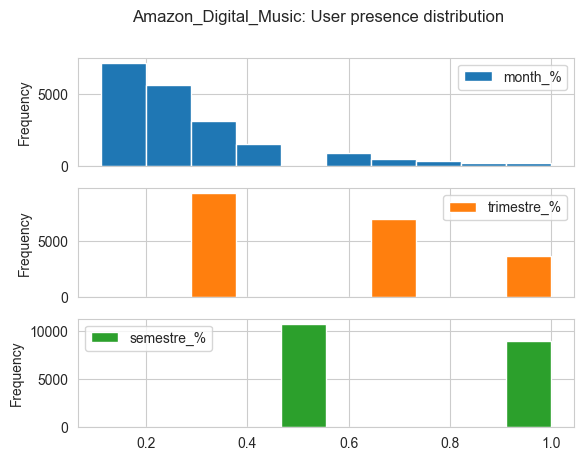

In [78]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

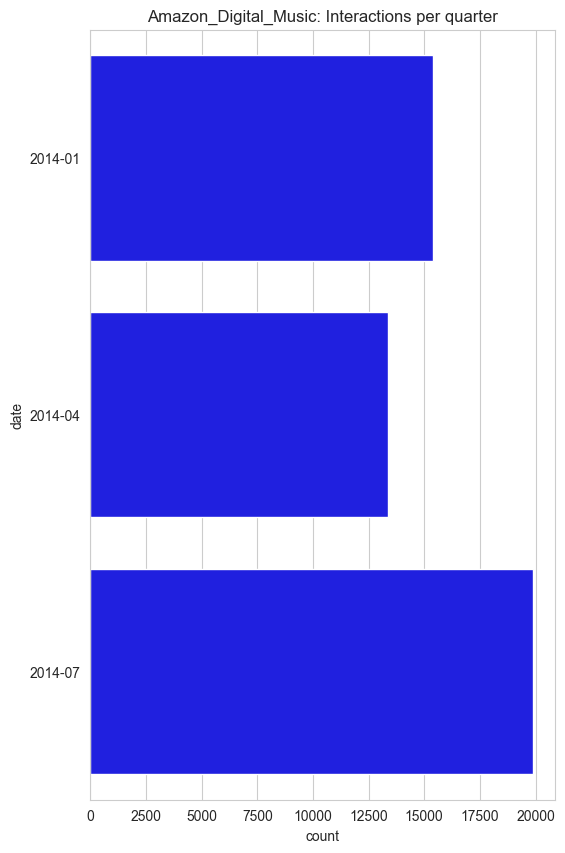

In [79]:
plot_interactions_per_qns(user_interactions=user_trimestre_interactions, 
                          date_range=trimestres, 
                          dataset_name=dataset_name, 
                          type_of_range='quarter')

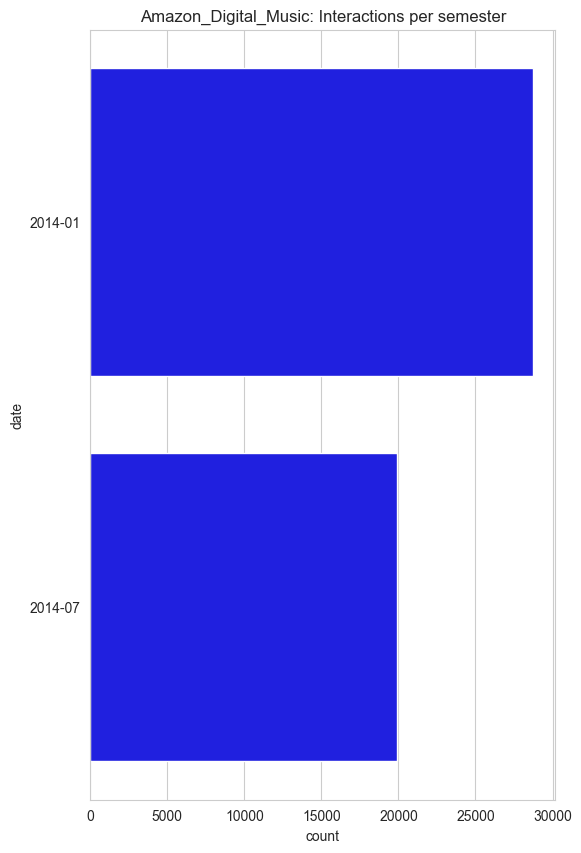

In [80]:
plot_interactions_per_qns(user_interactions=user_semestre_interactions, 
                          date_range=semestres,
                          dataset_name=dataset_name,
                          type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [81]:
# defining threshold
frequency_threshold = 1

In [87]:
# frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
frequent_users = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

249 users of 19850 (1.254%) occurr in 100% or more months.
3631 users of 19850 (18.292%) occurr in 100% or more quarters.
9049 users of 19850 (45.587%) occurr in 100% or more semesters.


In [88]:
frequent_users

(array(['B00CRMX53S', 'B007V5XV30', 'B00GB1OY54', 'B00DW22TSO',
        'B00EI6E17A', 'B009XJVKIU', 'B00137KH9S', 'B00F0AIE4E',
        'B00C6MPTT2', 'B0011Z77TA', 'B00GX9DUGS', 'B001KUU7X4',
        'B00GHS2KAM', 'B00CDX0UKC', 'B009G78L9U', 'B0099G7KDQ',
        'B007QNRC3W', 'B009VLX8FS', 'B001VFSNYS', 'B007QNRBRY',
        'B0046X7VAO', 'B005F1WJ62', 'B00137IJUM', 'B00DH72Y7U',
        'B00AHXDKO8', 'B0011Z310Y', 'B00FWJ99LK', 'B00ELD1RPY',
        'B006Z1XZFK', 'B002EX1EHY', 'B00F0AIBJC', 'B006ZDSAY4',
        'B00BWGHIHY', 'B00137KRYS', 'B001EJH4SW', 'B000SZBPAQ',
        'B0011Z8O2O', 'B0011Z8OFG', 'B00FSZZTXK', 'B00AAAKHZ8',
        'B00330UFQS', 'B00A7ZXBE0', 'B006H1ME5A', 'B00GBKIOWY',
        'B00H28284O', 'B00330WKMA', 'B00E4AQH68', 'B00A3M6PFY',
        'B01929H4VM', 'B00FW660EW', 'B00C0NFPTQ', 'B00DYLVD62',
        'B00970FKQ8', 'B00G7IXSNA', 'B000UQYT5Q', 'B00GG3OYMK',
        'B00AU1L44K', 'B0038YID1S', 'B00973AF0G', 'B009G8GTFM',
        'B004KBTH8G', 'B00C6MPHBC', 'B00

In [90]:
# old huge sample
# joblib.dump(frequent_users_month, 'output/amazonbooks_dump/frequent_users_month.joblib')

# new sample
joblib.dump(frequent_users, 'output/amazon_digmusic_dump/sample_frequent_users.joblib')

['output/amazon_digmusic_dump/sample_frequent_users.joblib']